In [33]:
import numpy as np
from soma import aims
import os
import sparse
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
from scipy.ndimage import rotate, affine_transform
import matplotlib.pyplot as plt
import random
from scipy.ndimage import map_coordinates
from deep_folding.brainvisa.utils.resample import resample

In [5]:
# remove zeros function
def trim_zeros(arr):
    """Returns a trimmed view of an n-D array excluding any outer
    regions which contain only zeros.
    """
    slices = tuple(slice(idx.min(), idx.max() + 1) for idx in np.nonzero(arr))
    return arr[slices], slices

In [503]:
#sulcus = 'CINGULATE.'
#main_sulcus = 'F.C.M.ant.'

sulcus = 'S.T.i.-S.T.s.-S.T.pol.'
#main_sulcus = 'S.C.'
side = 'L'
# before dilation ?
#mask_dir = f'/neurospin/dico/data/deep_folding/current/mask/2mm/L/{main_sulcus}_left.nii.gz'
mask_dir = f'/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/crops/2mm/{sulcus}/mask/{side}mask_cropped.nii.gz'
crops_dir = f'/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/2mm/{sulcus}/mask/{side}crops/'

In [504]:
mask = aims.read(mask_dir)
print(mask.np.shape)
print(mask.header())
s = sparse.COO.from_numpy(mask.np[:,:,:,0])
print(np.min(s.coords, axis=1))
print(np.max(s.coords, axis=1)) # the mask is trimmed
print(np.sum(mask.np!=0))

(34, 67, 57, 1)
{ 'volume_dimension' : [ 34, 67, 57, 1 ], 'sizeX' : 34, 'sizeY' : 67, 'sizeZ' : 57, 'sizeT' : 1, 'referential' : 'f122dcc2-417e-11ef-886d-a4bb6db7a741', 'disk_data_type' : 'S16', 'bits_allocated' : 16, 'data_type' : 'S16', 'scale_factor_applied' : 0, 'possible_data_types' : [ 'S16', 'FLOAT', 'DOUBLE' ], 'cal_min' : 0, 'cal_max' : 0, 'freq_dim' : 0, 'phase_dim' : 0, 'slice_dim' : 0, 'slice_code' : 0, 'slice_start' : 0, 'slice_end' : 0, 'slice_duration' : 0, 'storage_to_memory' : [ -1, 0, 0, 33, 0, -1, 0, 66, 0, 0, -1, 56, 0, 0, 0, 1 ], 'voxel_size' : [ 2, 2, 2, 1 ], 'tr' : 1, 'referentials' : [ 'Scanner-based anatomical coordinates' ], 'transformations' : [ [ -1, 0, 0, 34, 0, -1, 0, 65, 0, 0, -1, 55, 0, 0, 0, 1 ] ], 'toffset' : 0, 'xyz_units' : 0, 'time_units' : 0, 'descrip' : '', 'aux_file' : '', 'nifti_type' : 1, 'object_type' : 'Volume', 'file_type' : 'NIFTI-1' }
[0 0 0]
[33 66 56]
30078


In [505]:
# take density into account in the point cloud, if the mask is not binary !
data = [coords for coords, number in zip(s.coords.T, s.data) for i in range(number)]
print(np.unique(s.data))
data = np.vstack(data).T
# get principal directions of the data
#data = s.coords
cov = np.cov(data)
eval, evec = np.linalg.eig(cov)
print(eval)

[1]
[ 34.43145757  73.73712796 319.64730779]


In [506]:
means = np.mean(data, axis=1)
print(means)
centered_data = data - means[:,np.newaxis]
print(centered_data.shape)

[19.86149345 33.1566926  29.20812554]
(3, 30078)


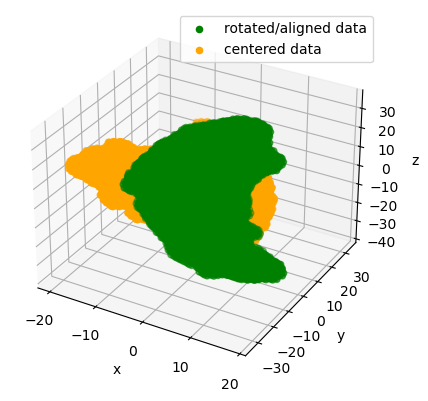

In [507]:
plt.close()
aligned_coords = np.matmul(evec.T, centered_data)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(aligned_coords[0,:], aligned_coords[1,:], aligned_coords[2,:], color='g', label="rotated/aligned data")
ax.scatter(centered_data[0,:], centered_data[1,:], centered_data[2,:], color='orange', label="centered data")
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [508]:
size_before = (np.max(centered_data,axis=1) - np.min(centered_data, axis=1)) + 1
print(f'bbox size before rotation : {size_before}')
size_after = (np.max(aligned_coords,axis=1) - np.min(aligned_coords, axis=1)) + 1
print(f'bbox size after rotation : {size_after}')
print(f'Extremities_after: {np.max(aligned_coords,axis=1)}, {np.min(aligned_coords, axis=1)}')
print(f'size ratio: {np.prod(size_after) / np.prod(size_before)}')

bbox size before rotation : [34. 67. 57.]
bbox size after rotation : [33.28310079 47.11977684 72.18959034]
Extremities_after: [18.36625125 21.05028567 34.2964549 ], [-13.91684954 -25.06949118 -36.89313544]
size ratio: 0.8719127070966491


In [509]:
# define the rotation matrix
rot_mat = evec
rot_mat = np.hstack((rot_mat, np.zeros((3,1))))
rot_mat = np.vstack((rot_mat, np.zeros(4)))
rot_mat[3,3]=1
print(rot_mat)

[[-0.93938513  0.34102038  0.03550594  0.        ]
 [-0.15095476 -0.50434519  0.85020503  0.        ]
 [-0.30784449 -0.79331018 -0.52525302  0.        ]
 [ 0.          0.          0.          1.        ]]


In [510]:
## pad the mask so that its dimensions are l*l*l, l=longueur de la grande diagonale du crop
dim = int(np.ceil(np.sqrt(mask.np.shape[0]**2 + mask.np.shape[1]**2 + mask.np.shape[2]**2)))
## center of mass is shift by l / 2 on each dimension
print(dim)
# output shape doesn't matter ?
# the padding must ensure each dimension to be larger than dim
# also, the padding should be an even number on each dimension
mask_dim = mask.np[:,:,:,0].shape
dims_to_pad = np.array([dim-m + (dim-m)%2 for m in mask_dim]) // 2
pad_width = [(d,d) for d in dims_to_pad]
print(dims_to_pad)
mask_padded = np.pad(mask.np[:,:,:,0], pad_width)
print(mask_padded.shape)
means_padded = means+dims_to_pad
print(means_padded)

95
[31 14 19]
(96, 95, 95)
[50.86149345 47.1566926  48.20812554]


In [511]:
## rotation must be performed around center of mass !
dx, dy, dz = mask_padded.shape[:3]
center = [dx / 2, dy / 2, dz / 2]
# the output shape must be increased by margin since rotation is not around center
margin = int(np.ceil(max([abs(m-c) for m,c in zip(means_padded, center)])))
print(center)
print(means_padded)
print(margin)


def compute_output_shape(image_shape, rotation_matrix):
    """Compute the shape of the output array that will contain all pixels after rotation."""
    # Original image corners
    corners = np.array([
        [0, 0, 0],
        [image_shape[0], 0, 0],
        [0, image_shape[1], 0],
        [0, 0, image_shape[2]],
        [image_shape[0], image_shape[1], 0],
        [image_shape[0], 0, image_shape[2]],
        [0, image_shape[1], image_shape[2]],
        [image_shape[0], image_shape[1], image_shape[2]]
    ])
    
    # Rotate corners
    rotated_corners = np.dot(rotation_matrix, corners.T).T
    
    # Find the min and max coordinates along each axis
    min_coords = rotated_corners.min(axis=0)
    max_coords = rotated_corners.max(axis=0)
    
    # Compute the size of the new bounding box
    output_shape = np.ceil(max_coords - min_coords).astype(int)
    
    return output_shape, min_coords

# find optimal output shape when performing rotation to lose no information
output_shape, min_coords = compute_output_shape(mask.np.shape[:3], evec.T)
print(output_shape, min_coords)

# add margin to output_shape since rotation is not around center
output_shape = [o+margin for o in output_shape]
shape = [max(output_shape) for k in range(len(output_shape))]
shape

[48.0, 47.5, 47.5]
[50.86149345 47.1566926  48.20812554]
3
[60 91 89] [-59.60019913 -79.00980762 -29.93942213]


[94, 94, 94]

from itertools import permutations

## try permutation of translations
m = means
l = list(permutations(m))

# permutation of eigen vectors
lperm = list(permutations(range(3)))

# track the size diff between the coordinates based rotation and matrix based (with interpolation)
mini_size_diff = 10

for m_ in l:
    for perm in lperm:
        print(m_, perm)
        rot_mat_perm = rot_mat[:, list(perm)]
        rot_mat_perm = np.hstack((rot_mat_perm, np.expand_dims(np.array([0,0,0,1]), axis=-1)))
        # shift to the mass center means
        dx, dy, dz = m_[0], m_[1], m_[2]

        shift = np.array(
            [
                [1, 0, 0, dx],
                [0, 1, 0, dy],
                [0, 0, 1, dz],
                [0, 0, 0,  1],
            ]
        )
        unshift = np.array(
            [
                [1, 0, 0, -dx],
                [0, 1, 0, -dy],
                [0, 0, 1, -dz],
                [0, 0, 0,   1],
            ]
        )

        trm = shift @ rot_mat_perm @ unshift

        ## apply transformation to mask to get new shape and slices

        b = affine_transform(mask.np[:,:,:,0], trm, output_shape=(150,150,150), order=0, mode='constant', cval=0.0)
        print(np.sum(mask.np))
        print(np.sum(b))
        c, slices = trim_zeros(b)
        print(c.shape)
        slices


In [512]:
# shift to the mass center means
#dx, dy, dz = means[1], means[2], means[0] ## STS, could be either 2,1,0 or 1,2,0
dx, dy, dz = means_padded[0], means_padded[1], means_padded[2] ##  S.Or., 1,0,2
# CINGULATE. : un board a l'air rogné, à cause de l'interpolation ? # non : en permutant aussi la translation on y arrive !
# S.C.-sylv : 2 dims correctes, la troisième est rognée... # la slice commence à 0 = bizarre ?

shift = np.array(
    [
        [1, 0, 0, dx],
        [0, 1, 0, dy],
        [0, 0, 1, dz],
        [0, 0, 0,  1],
    ]
)
unshift = np.array(
    [
        [1, 0, 0, -dx],
        [0, 1, 0, -dy],
        [0, 0, 1, -dz],
        [0, 0, 0,   1],
    ]
)

trm = shift @ rot_mat @ unshift

In [513]:
## apply transformation to mask to get new shape and slices

b = affine_transform(mask_padded, trm, output_shape=np.ceil(mask_padded.shape + means_padded).astype(int), order=0, mode='constant', cval=0.0)
print(np.sum(mask.np))
print(np.sum(b))
c, slices = trim_zeros(b)
print(c.shape)
print(f'volume ratio: {np.prod(c.shape) / np.prod(mask.shape)}')
print(slices)

30078
30072
(33, 47, 73)
volume ratio: 0.871979113719329
(slice(37, 70, None), slice(22, 69, None), slice(11, 84, None))


In [477]:
dataset = 'hcp'
arrs = np.load(f'/neurospin/dico/data/deep_folding/current/datasets/{dataset}/crops/2mm/{sulcus}/mask/{side}skeleton.npy')
foldlabels = np.load(f'/neurospin/dico/data/deep_folding/current/datasets/{dataset}/crops/2mm/{sulcus}/mask/{side}label.npy')
distbottoms = np.load(f'/neurospin/dico/data/deep_folding/current/datasets/{dataset}/crops/2mm/{sulcus}/mask/{side}distbottom.npy')
#dict_arrs = {'skeleton': arrs, 'foldlabel': foldlabels, 'distbottom': distbottoms}
dict_arrs = {'skeleton': arrs}

In [273]:
dict_rot_arrs = {}
print(f'Original dimension: {arrs.shape}')

for key, arrs in dict_arrs.items():
    print(f'ARRAY TYPE : {key}')
    if key=='distbottom':
        cval=32501
    else:
        cval=0
    arr_list = []
    print(f'Non zero voxels before rotation : {np.sum(arrs!=cval)}')
    for arr in tqdm(arrs):
        arr = arr[:,:,:,0]
        rot_arr = affine_transform(arr, trm, output_shape=shape, order=0, mode='constant', cval=cval)
        rot_arr = rot_arr[slices]
        arr_list.append(rot_arr)

    rot_arrs = np.stack(arr_list)
    print(f'Non zero voxels after rotation : {np.sum(rot_arrs!=cval)}')
    print(f'Dimension after rotation : {rot_arrs.shape}')
    # volume ration should be < 1 !
    print(f"volume ratio after / before rotation : {np.prod(rot_arrs.shape[1:]) / np.prod(arrs.shape[1:])}")
    # are topological values affected ?
    #print(np.unique(arrs, return_counts=True))
    #print(np.unique(rot_arrs_trimmed, return_counts=True))
    rot_arrs = np.expand_dims(rot_arrs, axis=-1)
    dict_rot_arrs[key]= rot_arrs

  2%|▏         | 18/1114 [00:00<00:06, 179.45it/s]

Original dimension: (1114, 30, 38, 22, 1)
ARRAY TYPE : skeleton
Non zero voxels before rotation : 757797


100%|██████████| 1114/1114 [00:06<00:00, 181.75it/s]

Non zero voxels after rotation : 734466
Dimension after rotation : (1114, 36, 31, 16)
volume ratio after / before rotation : 0.7119617224880382


In [274]:
# check that topological values are preserved

for key, arr in dict_arrs.items():
    rot_arr = dict_rot_arrs[key]
    if key=='distbottom':
        cval=32501
    else:
        cval=0

    print(f'Proportion of non-zero values after / before : {np.sum(rot_arr!=cval) / np.sum(arr!=cval)}')
    print(np.unique(arr, return_counts=True))
    print(np.unique(rot_arr, return_counts=True))

Proportion of non-zero values after / before : 0.9692120713066956
(array([ 0, 10, 30, 35, 40, 50, 60, 70, 80, 90], dtype=int16), array([27181323,      136,   152323,   139283,    15512,      388,
         430967,      368,    18819,        1]))
(array([ 0, 10, 30, 35, 40, 50, 60, 70, 80], dtype=int16), array([19157118,      126,   150471,   137028,    15313,      377,
         412971,      367,    17813]))
